## Google Colab setup (don't run locally)

In [1]:
from google.colab import drive
import os
import shutil

# Mount drive to colab
drive.mount('/content/drive', force_remount=True)

# setting up paths
path_to_project_files = '/content/drive/MyDrive/School/Homework/Spring2025/DL/Project/'
existing = os.path.join(path_to_project_files, 'kaggle.json')
path_to_colab_utils = '/root/.kaggle'
target = os.path.join(path_to_colab_utils, 'kaggle.json')

# move the key to the colab root
os.makedirs(path_to_colab_utils, exist_ok=True)
shutil.copy(existing, target)
os.chmod(target, 600)

# download the data into /content (which is temporary)
#!unzip '/content/drive/MyDrive/School/Homework/Spring2025/DL/Project/leafsnap_fixed_set.zip' -d '/content/leafsnap-dataset/'
#!kaggle datasets download -d xhlulu/leafsnap-dataset -p /content --unzip

Streaming output truncated to the last 5000 lines.
  inflating: /content/leafsnap-dataset/content/leafsnap-dataset/dataset/segmented/field/prunus_virginiana/13002166699296.png  
  inflating: /content/leafsnap-dataset/content/leafsnap-dataset/dataset/segmented/field/prunus_virginiana/13002169497407.png  
  inflating: /content/leafsnap-dataset/content/leafsnap-dataset/dataset/segmented/field/prunus_virginiana/13002166691656.png  
  inflating: /content/leafsnap-dataset/content/leafsnap-dataset/dataset/segmented/field/prunus_virginiana/13002175695976.png  
  inflating: /content/leafsnap-dataset/content/leafsnap-dataset/dataset/segmented/field/prunus_virginiana/13002175691058.png  
  inflating: /content/leafsnap-dataset/content/leafsnap-dataset/dataset/segmented/field/prunus_virginiana/13010820799435.png  
  inflating: /content/leafsnap-dataset/content/leafsnap-dataset/dataset/segmented/field/prunus_virginiana/13002166695366.png  
  inflating: /content/leafsnap-dataset/content/leafsnap-data

In [2]:
import sys

# Edit this path to where you've uploaded the repo files, so the imports work.
sys.path.append('/content/drive/MyDrive/School/Homework/Spring2025/DL/Project/')

## Library Imports

In [3]:
from autoencoder import *
from dataloader import *
from cnn import *

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os

In [4]:
import matplotlib.pyplot as plt

def showTensorInNotebook(tensor):
    """
    This takes a (3[RGB], H, W) tensor in R[0.0, 1.0] and displays it with matplotlib.
    """
    image = tensor.detach().cpu().numpy().transpose(1,2,0) # move the channel axis to the end, because PIL and matplotlib hate each other
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Building the data loader

These are transforms that allow us to ingest the image tensors with some extra confusion at training time. `processor` makes the data loader spit out tensors, and `noiser` adds Gaussian noise.

In [6]:
# This just processes the images.
NOISE_RATIO = 0.1
H, W = 256, 256

processor = v2.Compose([
    v2.PILToTensor(), # the LeafsnapDataset class gives PIL Images, convert to torch Tensor
    #lambda x: v2.functional.crop(x, 0, 0, 600, 600),
    #lambda x: print(x.size()),
    #lambda x: v2.RandomCrop(min(x.size()[1], x.size()[2]) - 75),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=(-45, 45)),
    v2.Resize((H, W)), # resize
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomPhotometricDistort(p=1),
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0), # add noise
])

lab_processor = v2.Compose([
    v2.PILToTensor(), # the LeafsnapDataset class gives PIL Images, convert to torch Tensor
    #lambda x: v2.functional.crop(x, 0, 0, 600, 600),
    #lambda x: v2.RandomCrop(min(x.size()[1], x.size()[2]) - 75),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=(-45, 45)),
    v2.Resize((H, W)), # resize
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomPhotometricDistort(p=1),
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0), # add noise
])

test_processor = v2.Compose([
    v2.PILToTensor(), # the LeafsnapDataset class gives PIL Images, convert to torch Tensor
    #lambda x: v2.functional.crop(x, 0, 0, 600, 600),
    v2.Resize((H, W)), # resize
    v2.ToDtype(torch.float32, scale=True),
])


In [7]:
BATCH_SIZE = 64

root_directory = os.path.join(os.getcwd(), 'leafsnap-dataset/content/leafsnap-dataset') # you make need to edit this path to work, though, it works on Colab by default and works locally if you keep the dataset at the root of the repo
train_image_paths_file = os.path.join(path_to_project_files, "train.txt")
train_dataset = LeafsnapDataset(train_image_paths_file, root_directory, use_segmented=False, source="both", expand_lab=True, max_expanded=2, transform=processor, lab_transform=lab_processor)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_image_paths_file = os.path.join(path_to_project_files, "validation.txt")
validation_dataset = LeafsnapDataset(validation_image_paths_file, root_directory, use_segmented=False, source="both", expand_lab=True, max_expanded=2, transform=processor, lab_transform=lab_processor)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_image_paths_file = os.path.join(path_to_project_files, "test.txt")
test_dataset = LeafsnapDataset(test_image_paths_file, root_directory, use_segmented=False, source="both", expand_lab=True, max_expanded=2, transform=test_processor, lab_transform=test_processor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_val_image_paths_file = os.path.join(path_to_project_files, "test_and_validation.txt")
test_val_dataset = LeafsnapDataset(test_val_image_paths_file, root_directory, use_segmented=False, source="both", expand_lab=True, max_expanded=2, transform=test_processor, lab_transform=test_processor)
test_val_dataloader = DataLoader(test_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training the Convolutional Neural Network (CNN)

This model uses a modified version of ResNet from Homework 2. It specifically is a version of ResNet34, with kernel size raised to 5, and skip layers at sizes 32, 64, and 128. Images have been downscaled to 128x128, and the segmentation image is used as a 4th layer, resulting in an input size of 4x128x128.

In [8]:
model = resnet(3, 185, device=device)
model.load_state_dict(torch.load(os.path.join(path_to_project_files, 'cnn_model.pth'), weights_only=True))

#train_resnet_model(model, train_dataloader, validation_dataloader, 20, .0001, device=device)

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), path_to_project_files + "cnn_model.pth")

## Testing the CNN

In [9]:
correct_top1 = 0
correct_top5 = 0
total = 0

model.to(device)
labels_list = torch.empty((0), dtype=torch.int32, device=device)
pred_list = torch.empty((0), dtype=torch.int32, device=device)
with torch.no_grad(): # No gradients needed for evaluation
    model.eval()
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Top-1 Accuracy
        _, predicted = torch.max(outputs, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 Accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices
        correct_top5 += torch.sum(top5_preds.eq(labels.view(-1, 1))).item()

        total += labels.size(0)

        labels_list = torch.cat((labels_list, labels))
        pred_list = torch.cat((pred_list, predicted))

# Compute accuracies
top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")


Top-1 Accuracy: 80.34%
Top-5 Accuracy: 95.61%


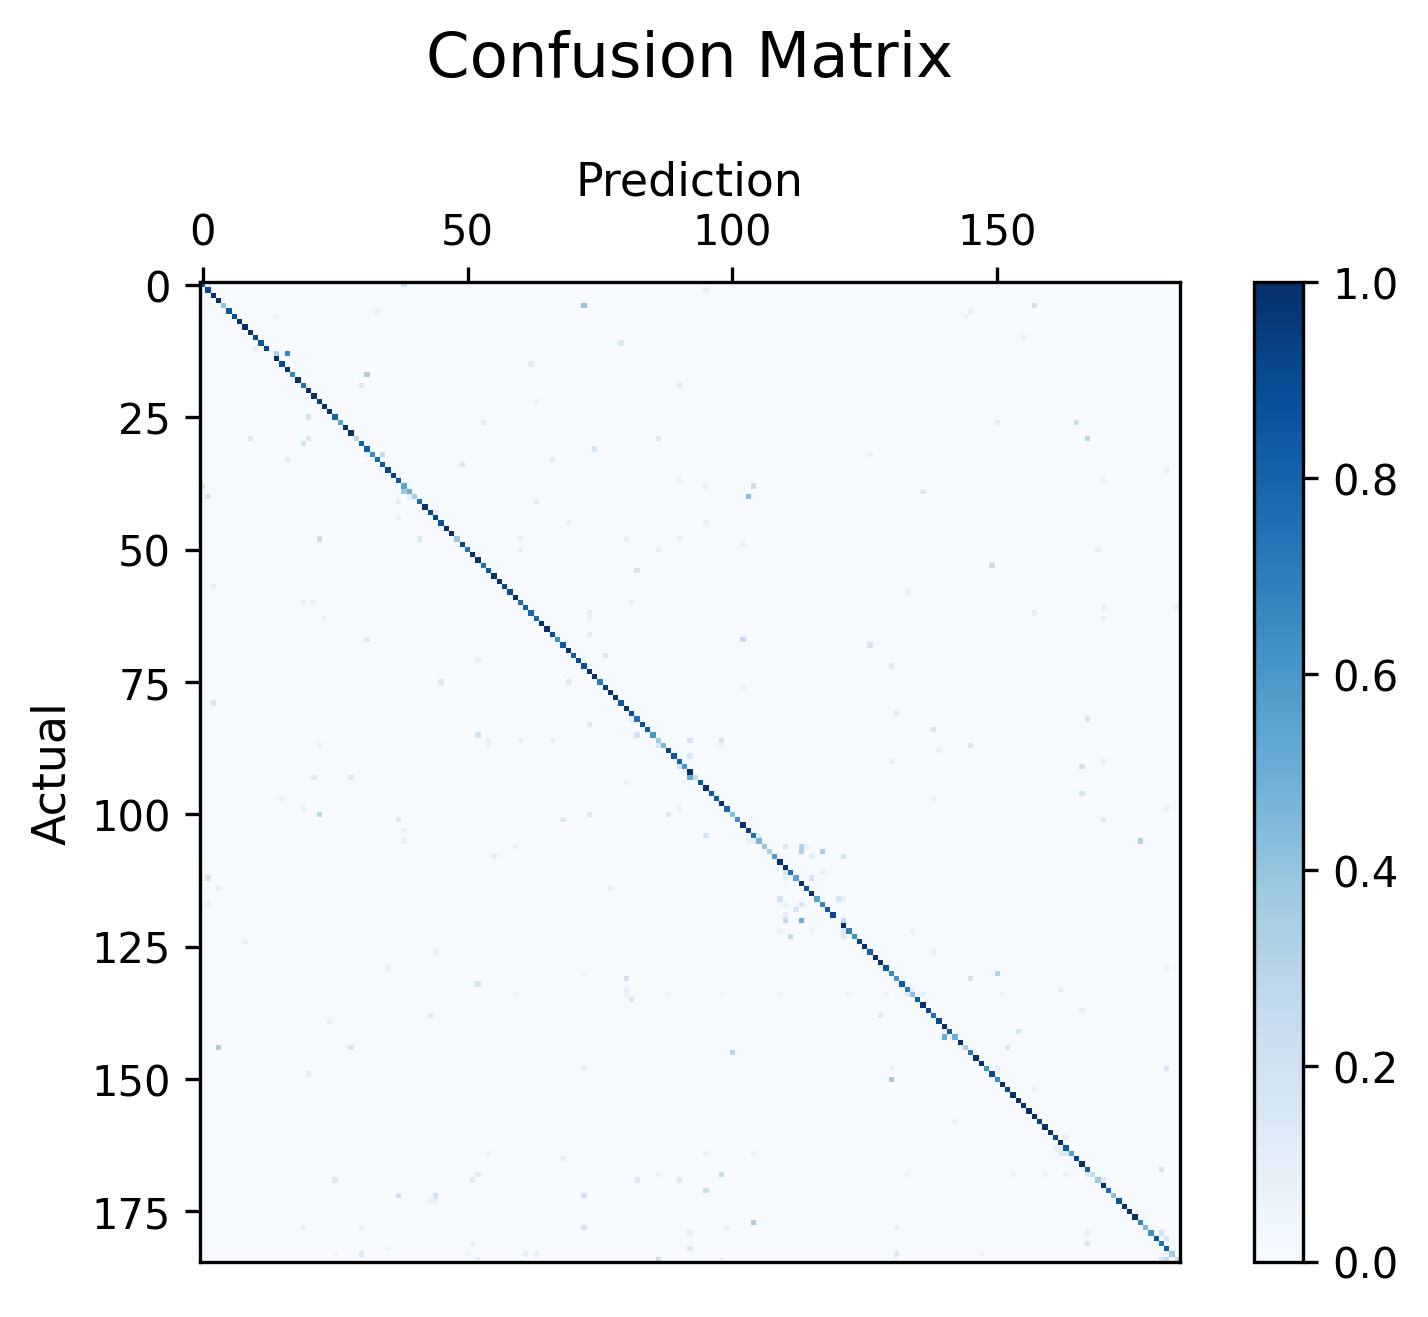

<Figure size 1920x1440 with 0 Axes>

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

classes = np.arange(185)
y_true = labels_list.cpu().numpy()
y_pred = pred_list.cpu().numpy()

cm = confusion_matrix(y_true, y_pred, labels=classes)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# disp.plot(cmap=plt.cm.Blues)
ticks=np.linspace(0, 184,num=185)
plt.imshow(cmn, interpolation='none', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.colorbar()
#plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


plt.show()
plt.savefig("ConfusionMatrix.png", dpi=300)

After various tweaks, I'm very happy with the current training accuracy of the CNN model, especially for the first check-in. Running at a 90% Top-5 accuracy is excellent, although there is certainly some more hyperparameter tweaking to be done. I may also test changing the model's structure, adding techniques such as dropout that have been used in other models for similar purposes. I would like to reach 80% Top-1 accuracy by the end.

In [ ]:
# image_list = list()
# #print(train_dataset.data)
# for data in validation_dataset.data:
#   img_path = os.path.join(root_directory, data[train_dataset.img_path_col])
#   image = Image.open(img_path).getdata()
#   image_list.append(image)

# print(image_list)

# rgb_values = np.concatenate(image_list, axis=0) / 255.

# mu_rgb = np.mean(rgb_values, axis=0)
# std_rgb = np.std(rgb_values, axis=0)

# print(mu_rgb)
# print(std_rgb)